<a href="https://colab.research.google.com/github/lahmidiamoumen/MobileNetV2-Segmentation/blob/main/MobileNetV2_fine_tuninig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Importing Libraries and Functions

In [ ]:
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision,Accuracy
from tensorflow.keras import backend as K
print("TensorFlow Version: ", tf.__version__)


**Seeding**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

**Hyperparameters**

In [ ]:
IMAGE_SIZE = 256
EPOCHS = 30
BATCH = 8
LR = 1e-4
PATH ="drive/My Drive/CVC-ClinicDB/*"
PATH_UNI ="drive/My Drive/CVC-612/*"

# **Reading the images and masks**

In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

# **Building the tf.data pipeline for training, validation and testing dataset.**



In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
   
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

# **Dataset**


In [ ]:
    
def load_data(path, split=0.1):

  images =sorted(glob.glob("drive/My Drive/CVC-ClinicDB/images/*"))
  masks = sorted(glob.glob("drive/My Drive/CVC-ClinicDB/masks/*"))
  
  total_size = len(images)
  valid_size = int(split * total_size)
  test_size = int(split * total_size)
  train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
  train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

  train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
  train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)
  return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
import glob 

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  490
Validation data:  61
Testing data:  61


In [ ]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

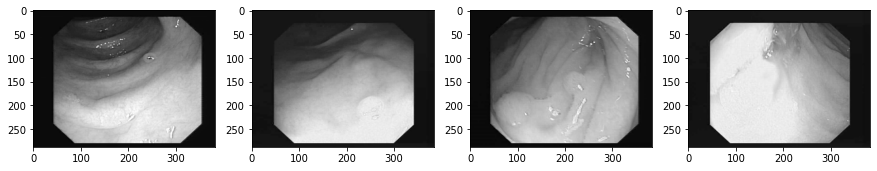

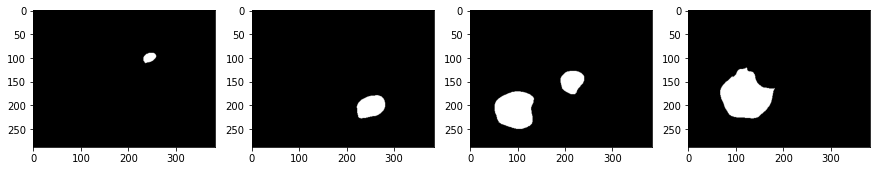

In [ ]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

# **MODEL** 

In [ ]:
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)

print("Number of layers in the base model: ", len(encoder.layers))

2023424/2019640 [==============================] - 0s 0us/step
Number of layers in the base model:  155


**Metrics**

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

TRAINING


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

def evaluation(num):
  test_steps = (len(test_x)//BATCH)
  if len(test_x) % BATCH != 0:
      test_steps += 1

  eval = model.evaluate(test_dataset, steps=test_steps)
  print("---------------Evaluation de niveau "+str(num)+"----------------------")
  print("-- loss: "+str(eval[0]))
  print("-- acc: "+str(eval[1]))
  print("-- recall_33: "+str(eval[2]))
  print("-- precision_33: "+str(eval[3]))
  print("-- dice_coef: "+str(eval[4]))
  # F-1 = 2 * (precision * recall) / (precision + recall)
  f_1 = 2 * (eval[3] * eval[2] ) / (eval[3] + eval[2] )
  print("-- F-1: "+str(eval[4]))

In [ ]:
# opt = tf.keras.optimizers.SGD(lr=LR, decay=1e-4, momentum=0.7, nesterov=False)
# opt = tf.keras.optimizers.Adam(LR)
def model_compile(lr=LR):
  opt = tf.keras.optimizers.Nadam(lr)
  metrics_unet = ["acc", Recall(), Precision(),dice_coef]
  model.compile(loss=dice_loss, optimizer=opt, metrics=metrics_unet)

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    tfdocs.modeling.EpochDots(),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

## Fonctions pour l'affichage des resultats

In [ ]:
# Utility function for plotting of the model results
def visualize_results(history,ii):
    # Plot the accuracy and loss curves
    acc = history.history['dice_coef']
    val_acc = history.history['val_dice_coef']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training dice_coef')
    plt.plot(epochs, val_acc, 'r', label='Validation dice_coef')
    plt.title('Training and validation accuracy niveau'+str(ii))
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training dice_loss')
    plt.plot(epochs, val_loss, 'r', label='Validation dice_loss')
    plt.title('Training and validation dice_loss niveau '+str(ii))
    plt.legend()

    plt.show()

def read_image_test(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask_test(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

def mask_parse_test(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

def show_result():
  for i, (x, y) in enumerate(zip(test_x[:10], test_y[:10])):
    x = read_image_test(x)
    y = read_mask_test(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse_test(y), white_line,
        mask_parse_test(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)

## Define the function for fiting the learning

In [ ]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

def model_fit(epochs = 80):
  return model.fit(
              train_dataset,
              validation_data=valid_dataset,
              epochs=epochs,
              verbose=0,
              steps_per_epoch=train_steps,
              validation_steps=valid_steps,
              callbacks=callbacks
          )

In [ ]:
# la list des nomes des layers disponible
for layr in model.layers:
  print(layr.name)

In [ ]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)

def build_model(skip_connection_names = ['input_image'], bridge = 'block_1_expand_relu', f = [128], train_all= False):
  
    x = encoder.get_layer(bridge).output

    if train_all :
      for layer in encoder.layers :
        if layer.name.endswith('_expand_relu') and layer.name.startswith('block_'):
            layer.trainable = True
    else:
      for i in range (len(encoder.layers)) :
        encoder.layers[i].trainable = False

    # Decodeur
    
    for i in range(1, len(skip_connection_names)+1):            
      x_skip = encoder.get_layer(skip_connection_names[-i]).output
      x = UpSampling2D((2, 2))(x)
      x = Concatenate()([x, x_skip])

      x = conv_block(x, f[-i])
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)

# Use the activations of these layers
# layer_names = [
#     "input_image",
#     'block_1_expand_relu',   # 64x64
#     'block_3_expand_relu',   # 32x32
#     'block_6_expand_relu',   # 16x16
#     'block_13_expand_relu',  # 8x8
#     'block_16_project',      # 4x4
# ]
# model = build_model(['input_image'], 'block_1_expand_relu' , [64])
#tf.keras.utils.plot_model(model, show_shapes=True)
#model.summary()

# Niveau 0 ( freeze all the layers) 

All the layers are freezen


In [ ]:
# compile and fit
# recompile the model and fit

model = build_model()
model_compile(lr=0.01)
history = model_fit(60)
evaluation(0)

model.save_weights("level_1.hdf5")


Epoch: 0, acc:0.7556,  dice_coef:0.3329,  loss:0.6688,  lr:0.0100,  precision_12:0.2268,  recall_12:0.6340,  val_acc:0.9107,  val_dice_coef:0.0359,  val_loss:0.9635,  val_precision_12:0.3259,  val_recall_12:0.0174,  
8/8 [==============================] - 0s 54ms/step - loss: 0.5970 - acc: 0.8447 - recall_12: 0.5510 - precision_12: 0.3311 - dice_coef: 0.4021
---------------Evaluation de niveau 0----------------------
-- loss: 0.5969716906547546
-- acc: 0.8447323441505432
-- recall_33: 0.5509902238845825
-- precision_33: 0.3311016857624054
-- dice_coef: 0.4021345376968384
-- F-1: 0.4021345376968384


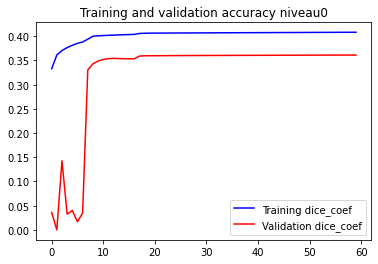

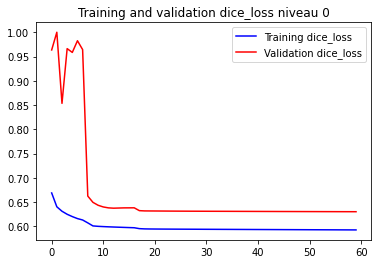

In [ ]:
# learning rate for loss and accurany
visualize_results(history,0)

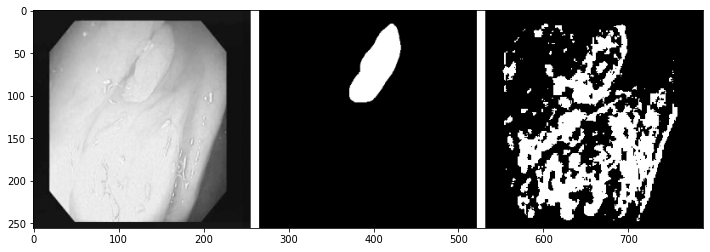

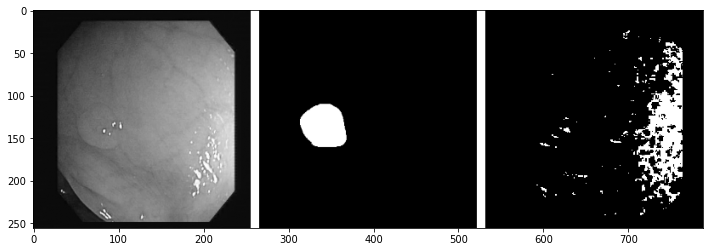

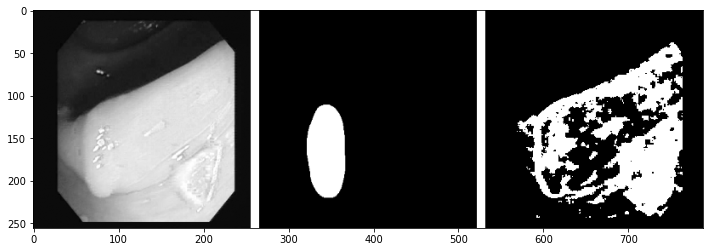

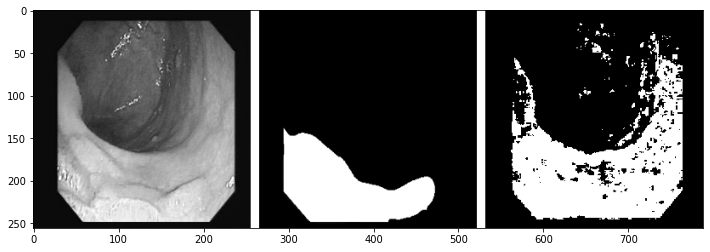

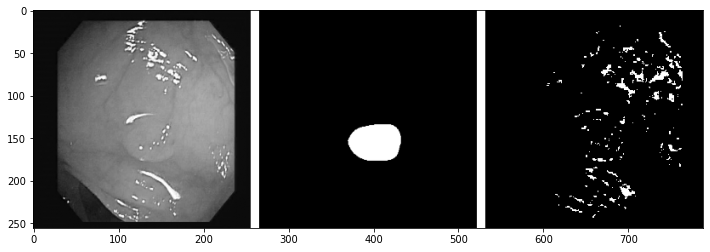

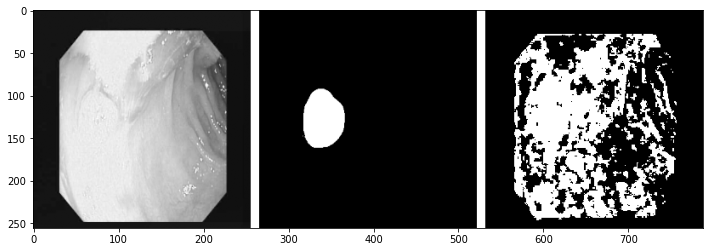

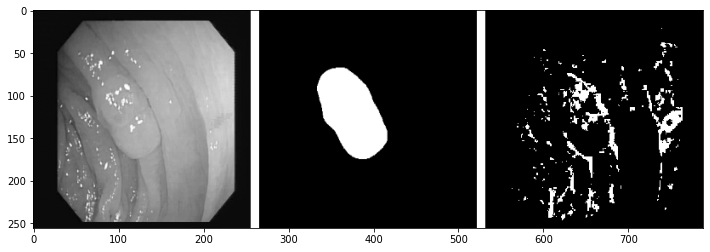

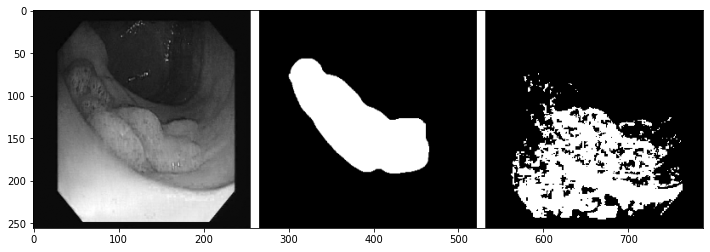

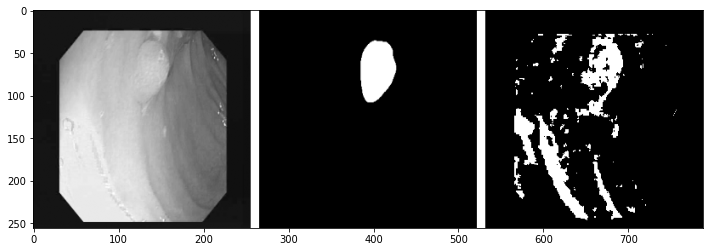

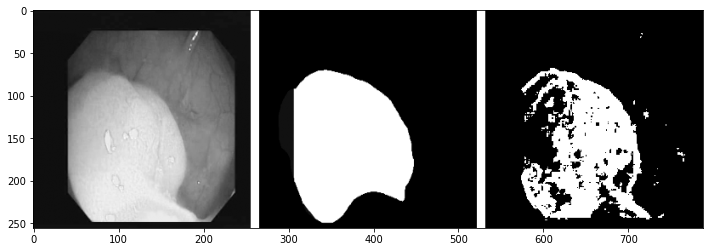

In [ ]:
# afficher les resultats pr le nv 0
show_result()

# Niveau 1 (train 2 layers) decoder

* We have 13 blocks and 155 layers in total.

* fine tune only 2 blocks on top of decoder .

In [ ]:

# recompile the model and fit
skip_connection_names = [
            'input_image',
            'block_1_expand_relu',   # 64x64
            'block_3_expand_relu',   # 32x32
          ]

f = [ 32, 48, 64]
model = build_model(skip_connection_names, 'block_6_expand_relu' , f)

model_compile(lr = 0.001)
history = model_fit()
evaluation(1)

model.save_weights("level_1.hdf5")


Epoch: 0, acc:0.7492,  dice_coef:0.3246,  loss:0.6758,  lr:0.0010,  precision_13:0.2432,  recall_13:0.7534,  val_acc:0.4523,  val_dice_coef:0.1978,  val_loss:0.7987,  val_precision_13:0.1251,  val_recall_13:0.8702,  
8/8 [==============================] - 0s 55ms/step - loss: 0.3420 - acc: 0.9344 - recall_13: 0.6154 - precision_13: 0.6975 - dice_coef: 0.6571
---------------Evaluation de niveau 1----------------------
-- loss: 0.3420160114765167
-- acc: 0.9343752264976501
-- recall_33: 0.6153926253318787
-- precision_33: 0.6975206136703491
-- dice_coef: 0.657050371170044
-- F-1: 0.657050371170044


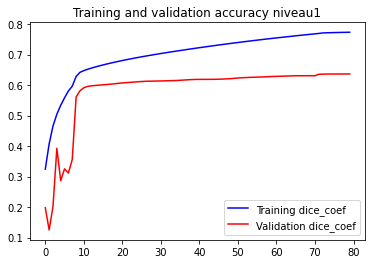

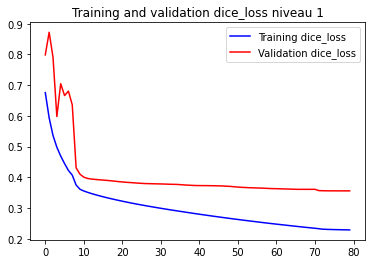

In [ ]:
visualize_results(history,1)

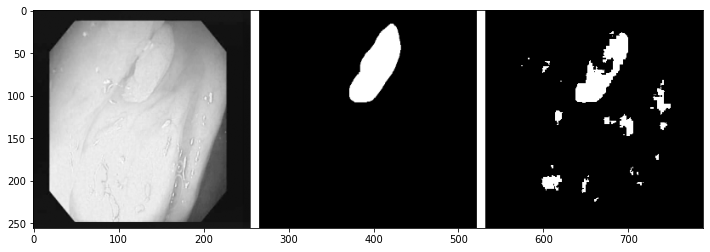

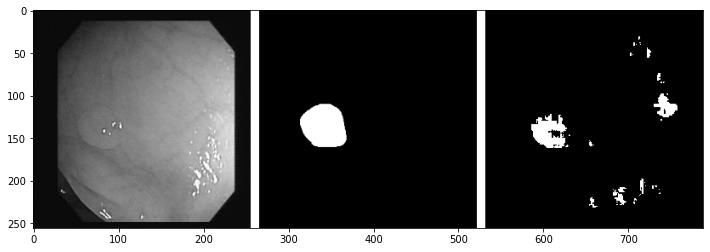

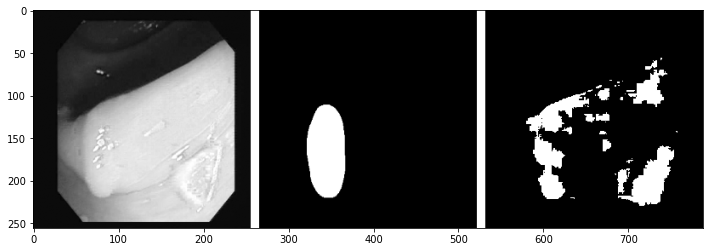

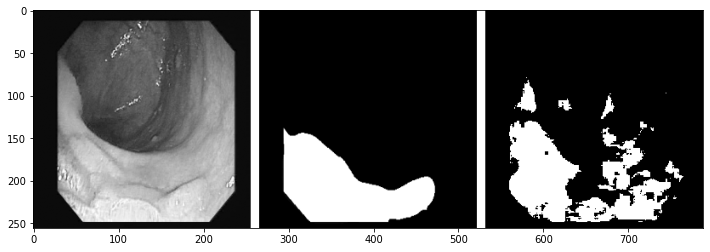

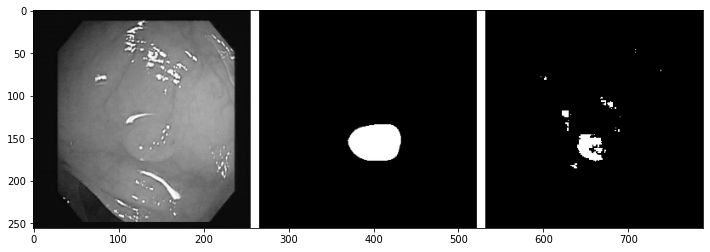

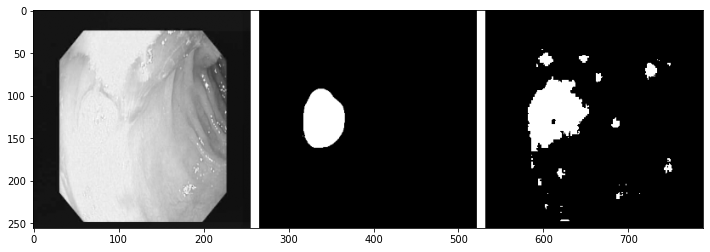

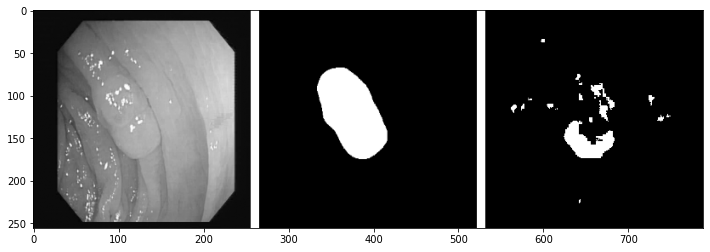

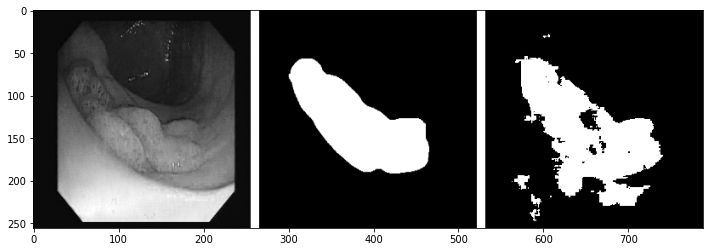

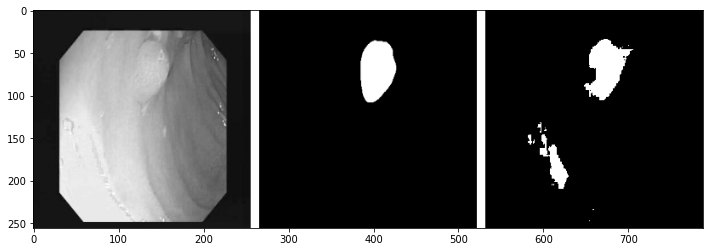

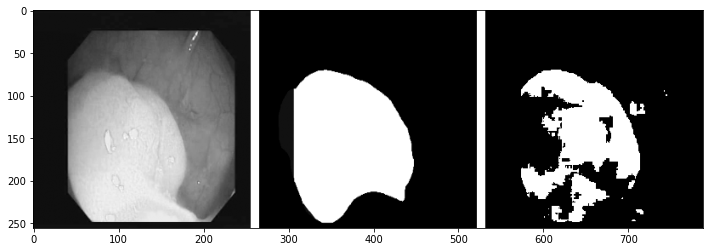

In [ ]:
# afficher les resultats pr le nv 1
show_result()

# Niveau 2 (train 3 layers) decoder

* We have 13 blocks and 155 layers in total.

* fine tune only 3 block on top of the decoder.

In [ ]:
skip_connection_names = [
            'input_image',
            'block_1_expand_relu',   # 64x64
            'block_3_expand_relu',   # 32x32
            'block_6_expand_relu',   # 16x16              
          ]

f = [16, 32, 48, 64]

model = build_model(skip_connection_names,'block_13_expand_relu', f)

model_compile(0.0001)
history = model_fit()

# evaluate the model
evaluation(2)

# save the model
model.save_weights("level_2.hdf5")


Epoch: 0, acc:0.6819,  dice_coef:0.2625,  loss:0.7372,  lr:0.0001,  precision_14:0.2092,  recall_14:0.8233,  val_acc:0.5098,  val_dice_coef:0.1979,  val_loss:0.7986,  val_precision_14:0.1474,  val_recall_14:0.9513,  
8/8 [==============================] - 0s 56ms/step - loss: 0.2643 - acc: 0.9536 - recall_14: 0.7111 - precision_14: 0.8094 - dice_coef: 0.7364
---------------Evaluation de niveau 2----------------------
-- loss: 0.26433858275413513
-- acc: 0.9535542726516724
-- recall_33: 0.7110850811004639
-- precision_33: 0.8094424605369568
-- dice_coef: 0.7363626956939697
-- F-1: 0.7363626956939697


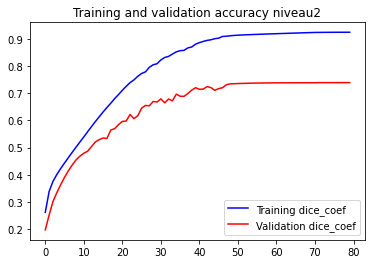

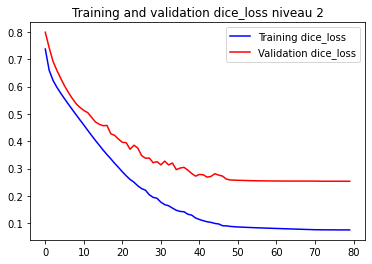

In [ ]:
# learning rate for loss and acc nv 2
visualize_results(history,2)

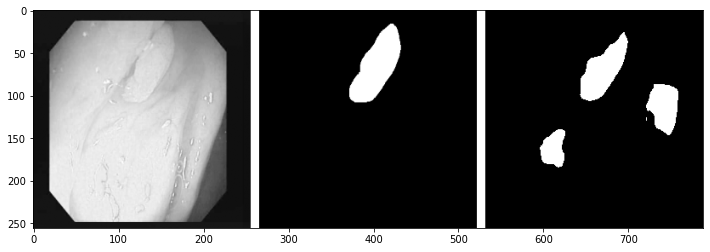

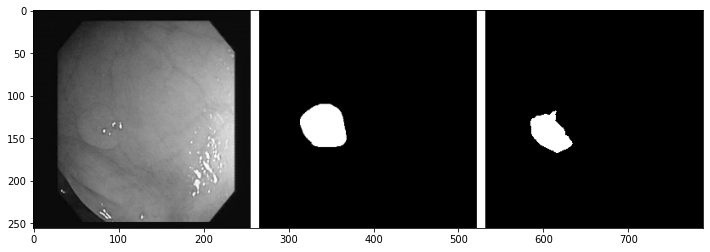

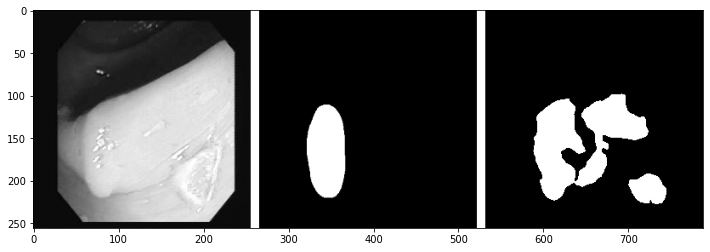

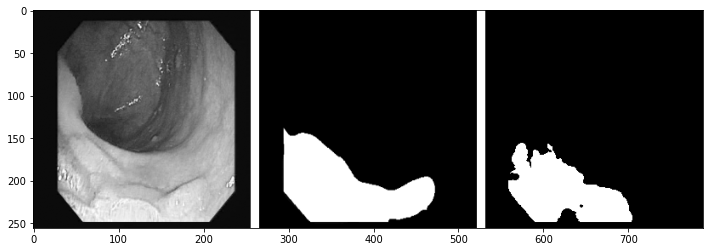

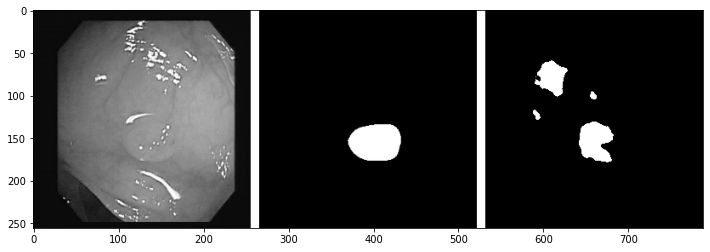

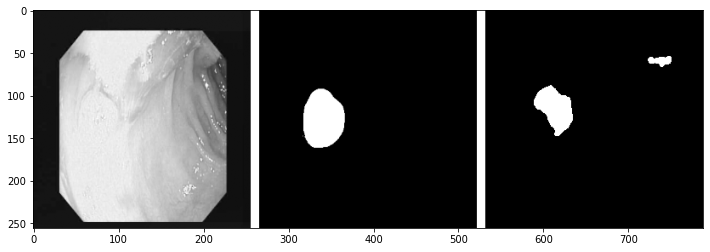

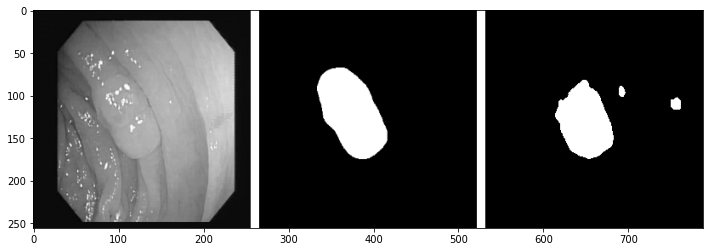

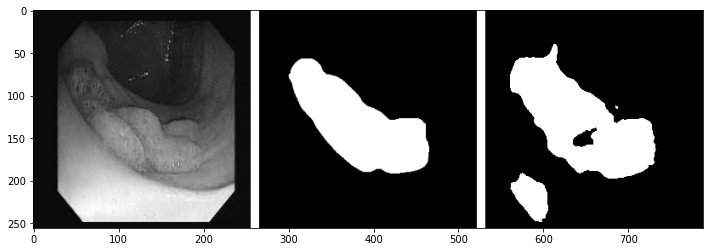

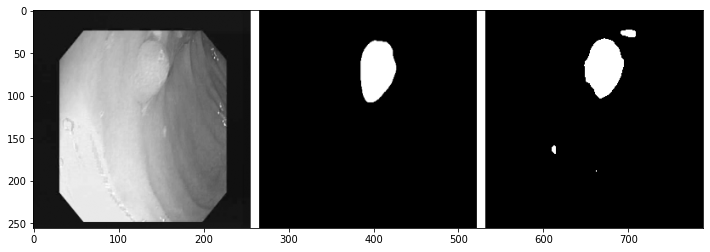

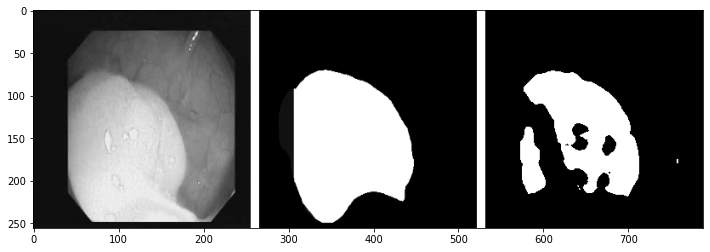

In [ ]:
# afficher les resultats pr le nv 1
show_result()

#Niveau 3 (train 4 layers) decoder

In [ ]:
skip_connection_names = [
            'input_image',
            'block_1_expand_relu',   # 64x64
            'block_3_expand_relu',   # 32x32
            'block_6_expand_relu',   # 16x16              
            'block_13_expand_relu',  # 8x8
          ]

f = [8 ,16, 32, 48, 64]

model = build_model(skip_connection_names, 'block_16_project' , f)
# fit the model the learning rate parameters
# defualt set lr = 0.0001
model_compile(lr=0.002)

# fit the model the epochs parameters
# defualt set epochs = 80 with eraly stoping 
history = model_fit(epochs = 40)

# evaluate the model
evaluation(3)

# save the model
model.save_weights("level_3.hdf5")


Epoch: 0, acc:0.8270,  dice_coef:0.3365,  loss:0.6631,  lr:0.0020,  precision_15:0.3351,  recall_15:0.7886,  val_acc:0.7396,  val_dice_coef:0.2652,  val_loss:0.7306,  val_precision_15:0.2421,  val_recall_15:0.9060,  
8/8 [==============================] - 0s 55ms/step - loss: 0.1563 - acc: 0.9659 - recall_15: 0.8017 - precision_15: 0.8604 - dice_coef: 0.8417
---------------Evaluation de niveau 3----------------------
-- loss: 0.15634725987911224
-- acc: 0.9659426212310791
-- recall_33: 0.8017153739929199
-- precision_33: 0.8604180216789246
-- dice_coef: 0.8416839241981506
-- F-1: 0.8416839241981506


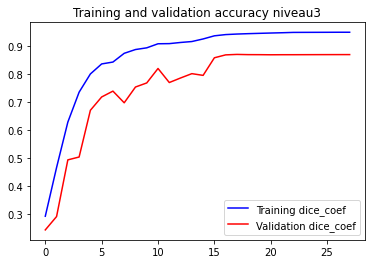

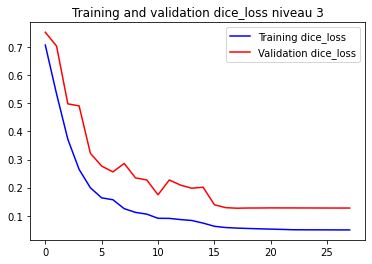

In [ ]:
visualize_results(history,3)

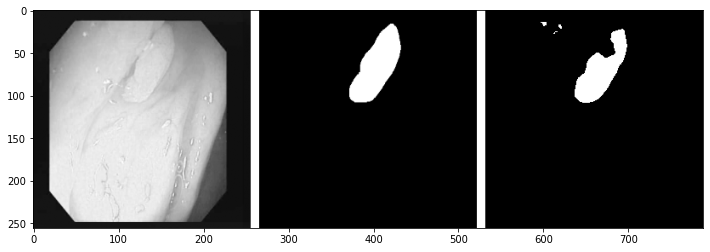

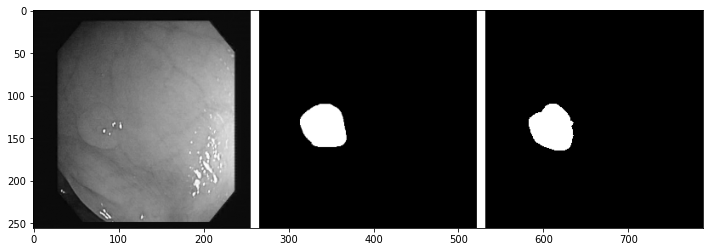

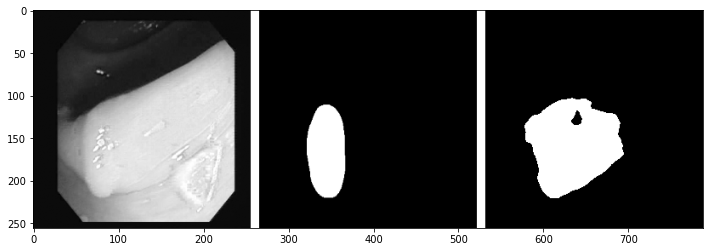

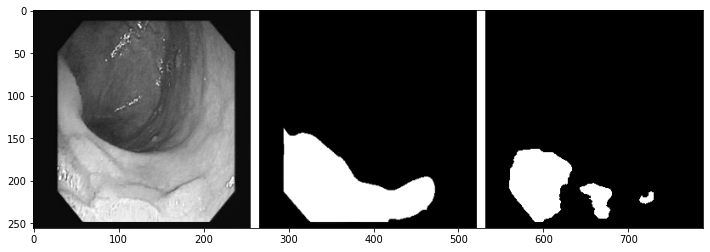

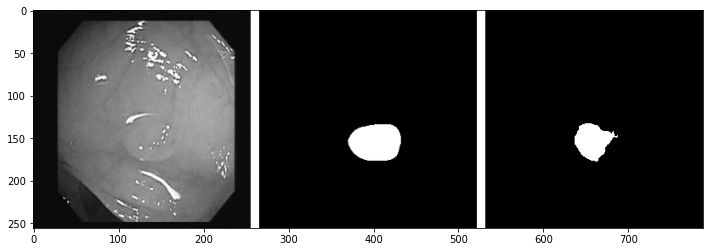

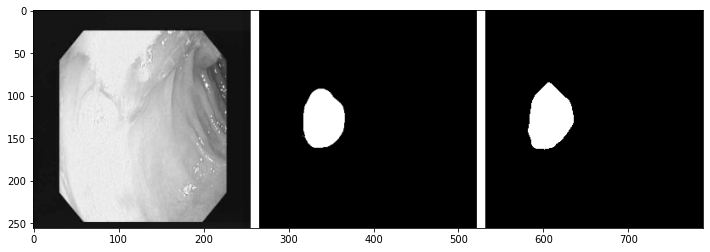

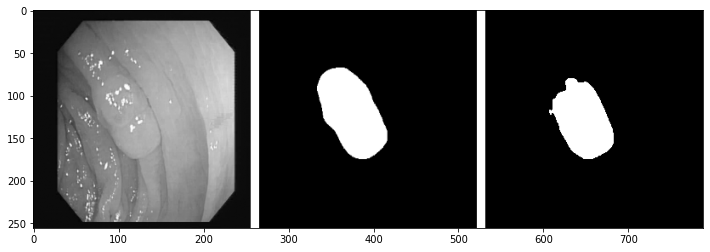

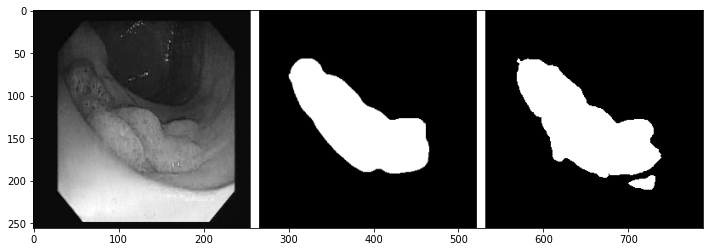

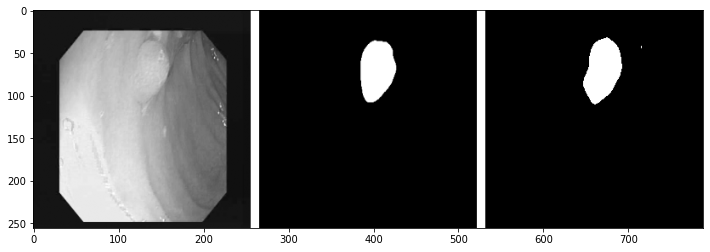

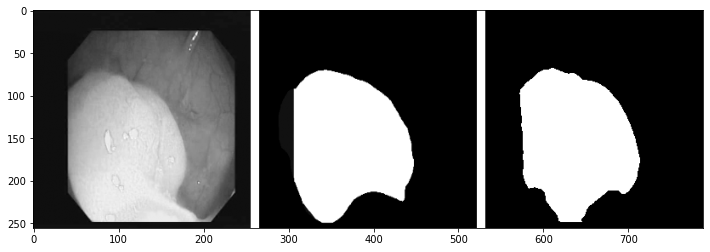

In [ ]:
show_result()

# Niveau 4 (train all the layers)

In [ ]:
model = build_model(train_all=True)
# fit the model the learning rate parameters
# defualt set lr = 0.0001
model_compile(lr=0.006)

# fit the model the epochs parameters
# defualt set epochs = 80 with eraly stoping 
history = model_fit(epochs = 80)

# evaluate the model
evaluation(4)

# save the model
model.save_weights("level_4.hdf5")


Epoch: 0, acc:0.7665,  dice_coef:0.3382,  loss:0.6634,  lr:0.0060,  precision_17:0.2377,  recall_17:0.6407,  val_acc:0.9124,  val_dice_coef:0.0000,  val_loss:1.0000,  val_precision_17:0.0000,  val_recall_17:0.0000,  
8/8 [==============================] - 0s 57ms/step - loss: 0.5891 - acc: 0.8516 - recall_17: 0.5443 - precision_17: 0.3443 - dice_coef: 0.4105
---------------Evaluation de niveau 4----------------------
-- loss: 0.5890665650367737
-- acc: 0.851645290851593
-- recall_33: 0.5442662835121155
-- precision_33: 0.34425321221351624
-- dice_coef: 0.41045477986335754
-- F-1: 0.41045477986335754


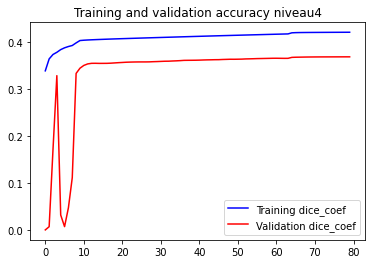

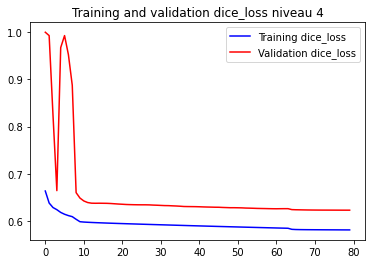

In [ ]:
visualize_results(history,4)

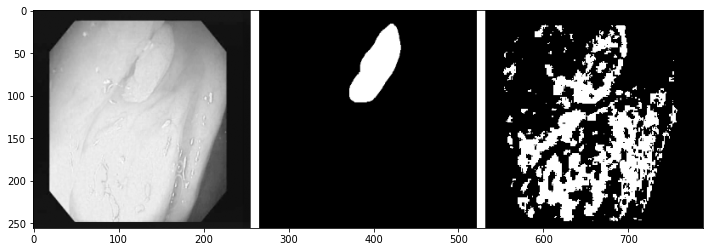

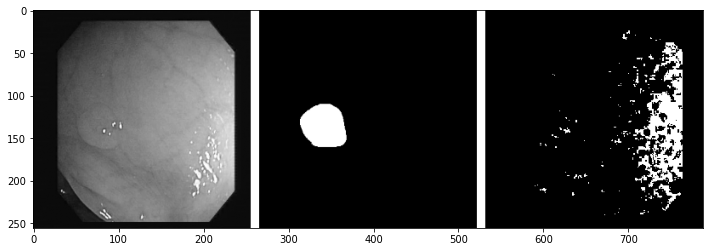

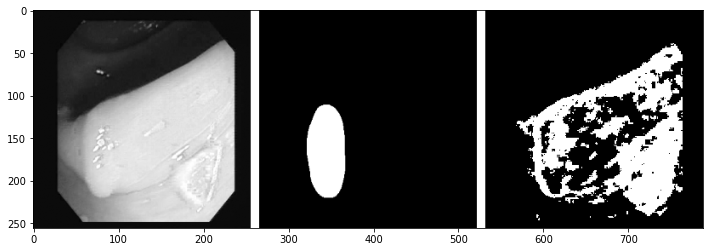

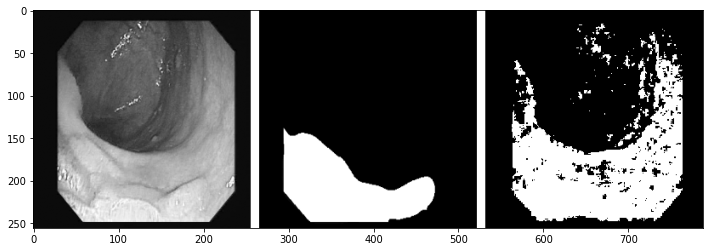

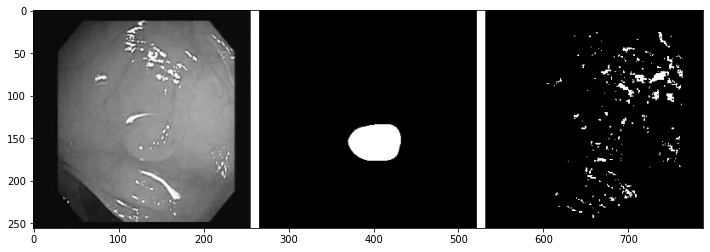

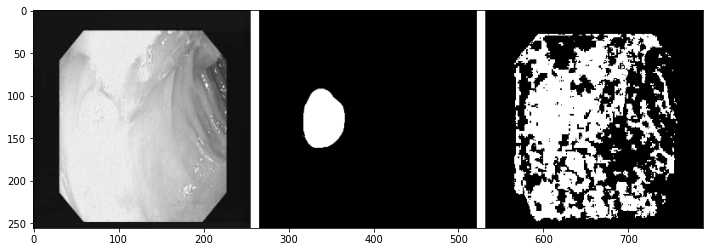

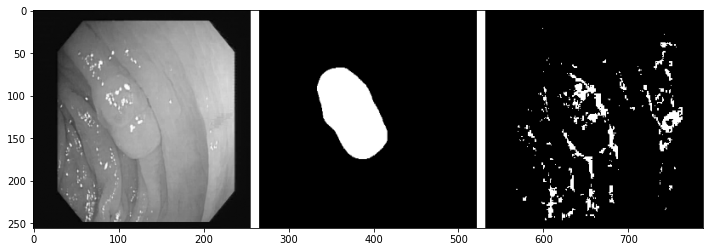

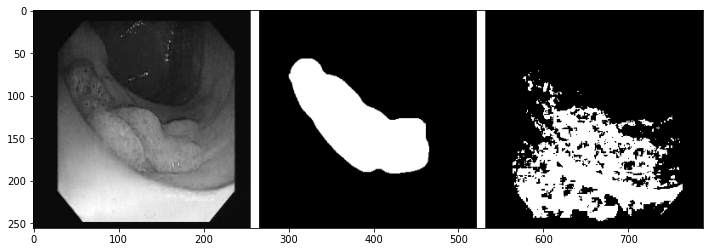

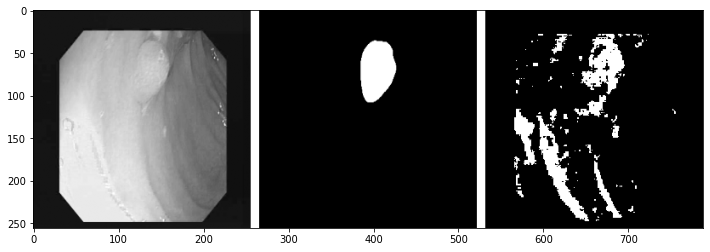

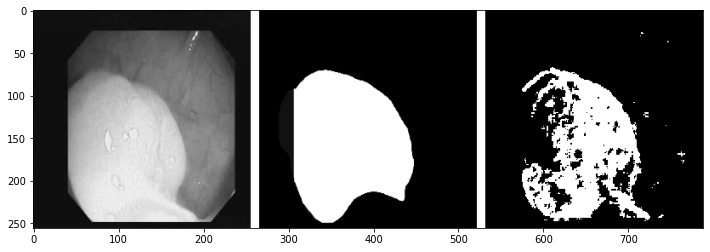

In [ ]:
show_result()

# Niveau 5 Train encoder
* train the 3 first layers in top of the encoder

In [ ]:
def encod_unfreeze():
    unfreeze_layer = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
    ]

    # freeze all layers encoder + decoder
    encoder.trainable = False


    # unfreeze some layers on encoder
    for layer_name in unfreeze_layer :
      encoder.get_layer(layer_name).trainable = True

    # reshape the last block in decoder to match the input_image
    x = encoder.get_layer('block_1_expand_relu').output

    x_skip = encoder.get_layer('input_image').output
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, x_skip])

    x = conv_block(x, 64)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)
    
model = encod_unfreeze()
# fit the model the learning rate parameters
# defualt set lr = 0.0001
model_compile(lr=0.003)

# fit the model the epochs parameters
# defualt set epochs = 80 with eraly stoping 
history = model_fit(epochs = 80)

# evaluate the model
evaluation(5)

# save the model
model.save_weights("level_5.hdf5")


Epoch: 0, acc:0.7344,  dice_coef:0.3212,  loss:0.6797,  lr:0.0030,  precision_19:0.2231,  recall_19:0.7034,  val_acc:0.8849,  val_dice_coef:0.1530,  val_loss:0.8461,  val_precision_19:0.1917,  val_recall_19:0.0968,  
8/8 [==============================] - 0s 55ms/step - loss: 0.5970 - acc: 0.8434 - recall_19: 0.5580 - precision_19: 0.3299 - dice_coef: 0.4023
---------------Evaluation de niveau 5----------------------
-- loss: 0.5969712138175964
-- acc: 0.8434195518493652
-- recall_33: 0.5579715967178345
-- precision_33: 0.3299455940723419
-- dice_coef: 0.4023231565952301
-- F-1: 0.4023231565952301


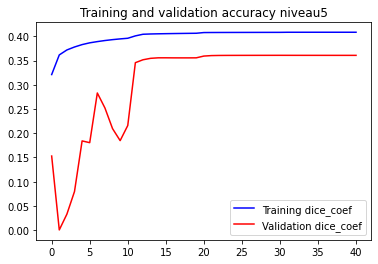

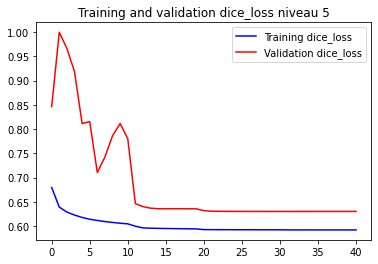

In [ ]:
visualize_results(history,5)

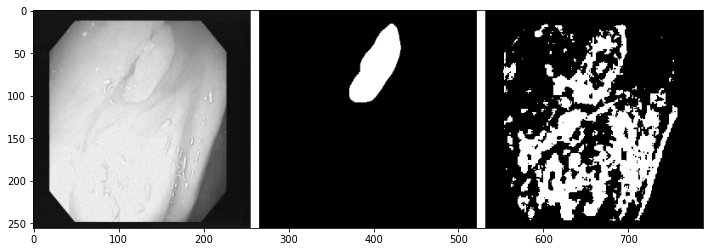

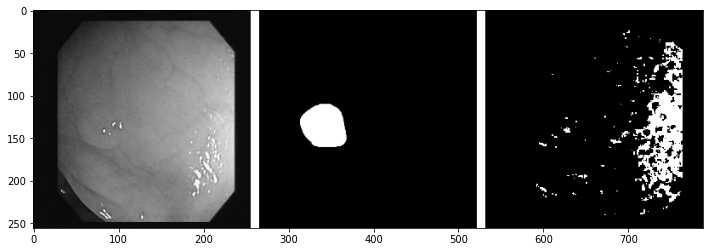

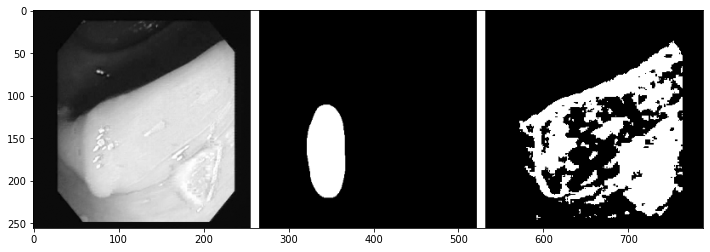

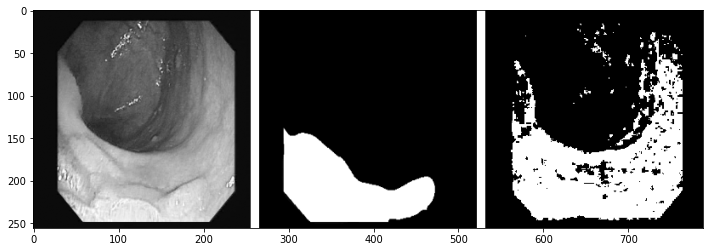

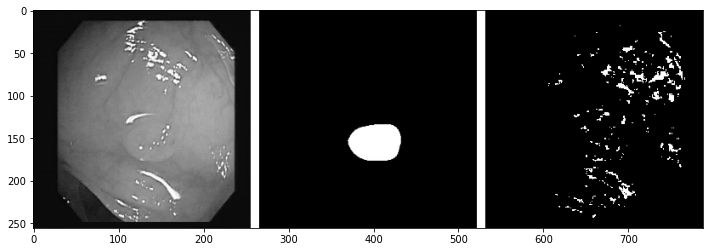

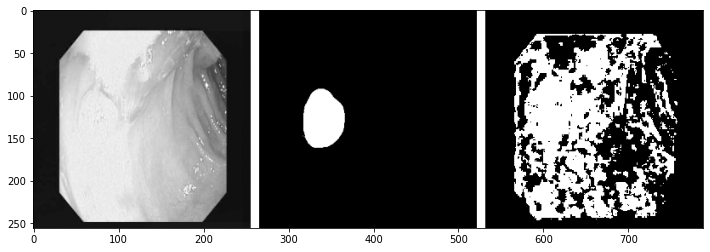

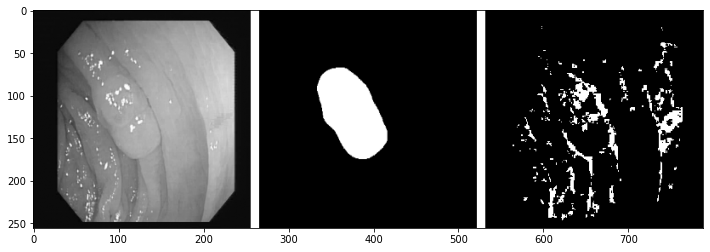

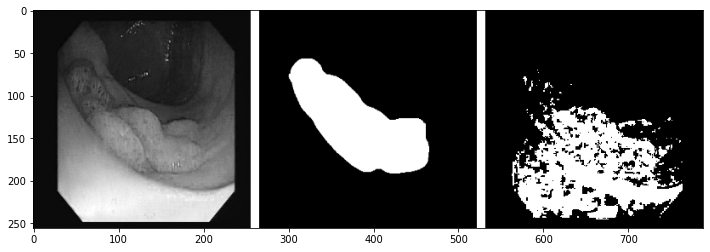

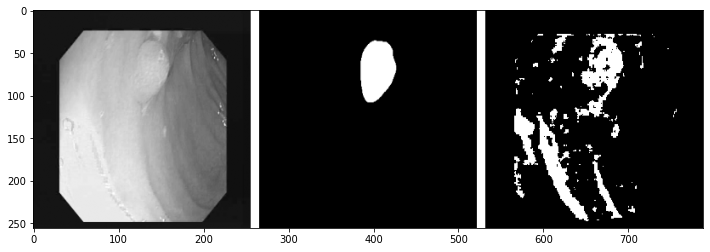

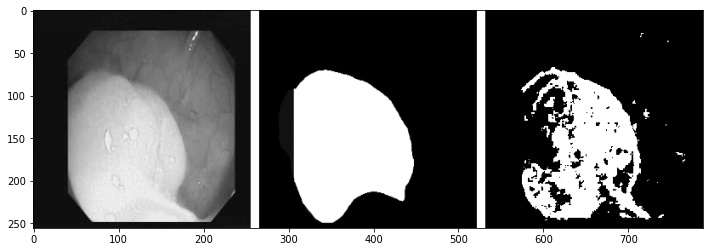

In [ ]:
show_result()